### Target : SA101_150_V_01.fits

#### Import all required libraries and path to files

In [1]:
from astropy.io import fits
import ccdproc
import photutils
import matplotlib.pyplot as plt
import os, glob

In [2]:
import numpy as np

In [3]:
from astropy.stats import sigma_clipped_stats, SigmaClip, mad_std #file statistics

In [4]:
filepath='/home/abhishek/ATSOA/atsoa_2022/sa101_standard/'
os.chdir(filepath)

In [5]:
bias_list=sorted(glob.glob('BIAS*.fits'))
flat_V_list=sorted(glob.glob('flat_V*.fits'))
sci_list=sorted(glob.glob('SA101_150_V*.fits'))
print('Bias files no:',len(bias_list))
print('Flat V band no.:',len(flat_V_list))
print('Science V band no.:',len(sci_list))

Bias files no: 2
Flat V band no.: 4
Science V band no.: 12


#### Making masterbias

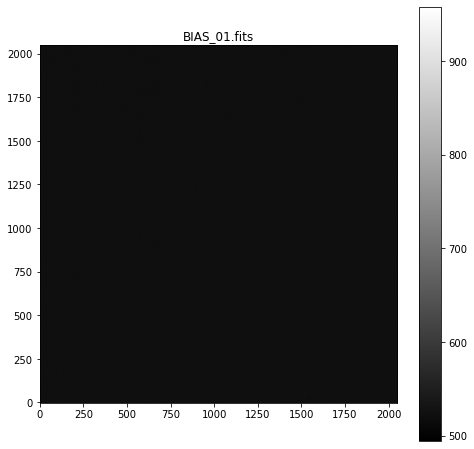

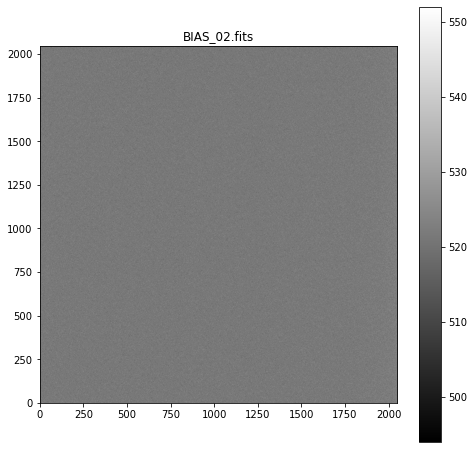

In [6]:
j=1
for i in range(len(bias_list)): #loop over the files to plot bias
    bias=fits.open(bias_list[i])
    image=bias[0].data
    image=image[0]
    bias.close()
    plt.figure(figsize=(8,8))
    plt.imshow(image,aspect='equal',origin='lower',cmap='gray')
    plt.title(bias_list[i])
    plt.colorbar()
    #plt.savefig(f'/home/abhishek/ATSOA/Photometry project/Project PPT/BIAS_{j}.png',facecolor='white',edgecolor='white')
    j+=1

In [7]:
biaslist=[]
for i in range(len(bias_list)):
    data=ccdproc.CCDData.read(bias_list[0],unit='adu')
    header=data.header
    biaslist.append(data[0]) #take care of additional axis
    
#print(biaslist) #if you want to print list
masterbias=ccdproc.combine(biaslist,method='median')

#fits.writeto('masterbias.fits',masterbias,header,overwrite=True) #requires header and data both

/home/abhishek/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


522.0 3.971274305450932


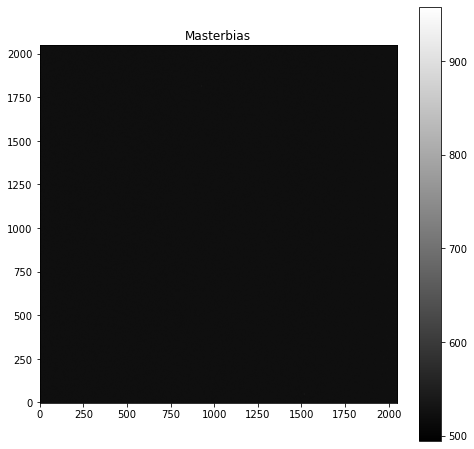

In [8]:
plt.figure(figsize=(8,8))
plt.imshow(masterbias,aspect='equal',origin='lower',cmap='gray')
plt.colorbar()
plt.title('Masterbias')
#plt.savefig('/home/abhishek/ATSOA/Photometry project/Project PPT/masterbias.png',facecolor='white',edgecolor='white')
print(np.median(masterbias),np.std(masterbias))

#### Making masterflat for V band

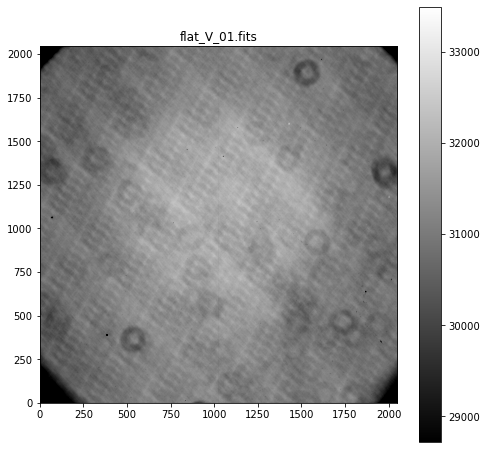

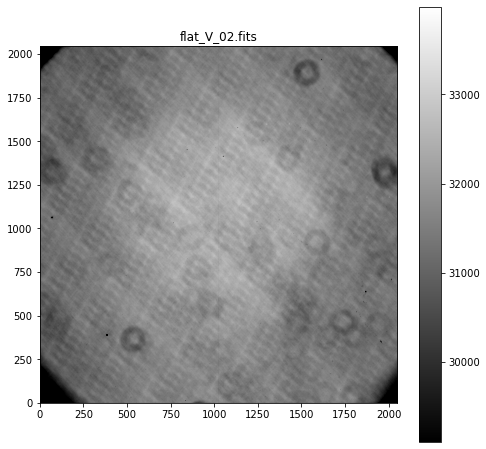

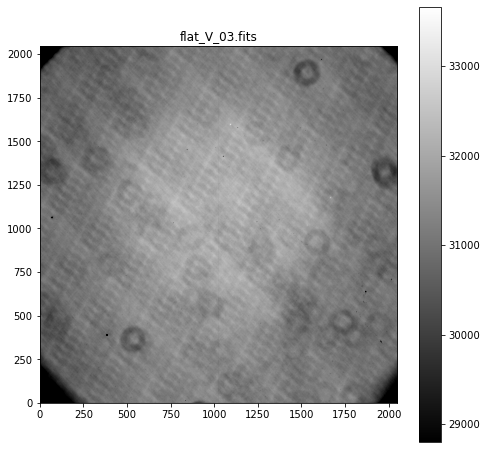

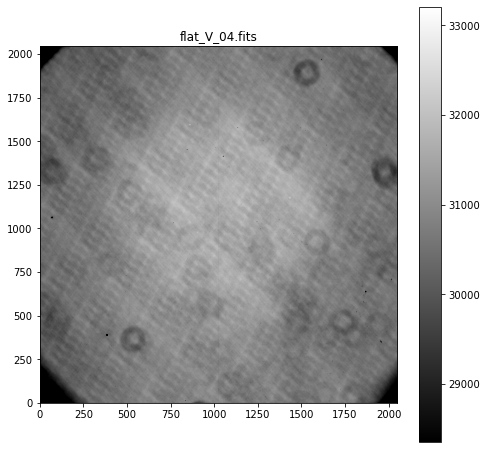

In [9]:
j=1
for i in range(len(flat_V_list)):
    flat=fits.open(flat_V_list[i])
    header=flat[0].header
    image=flat[0].data
    #image=image[0] #get rid of extra axis
    mean,median,std=sigma_clipped_stats(image) #get statistics
    plt.figure(figsize=(8,8))
    plt.imshow(image,vmax=median+5*std,vmin=median-5*std,aspect='equal',origin='lower',cmap='gray')
    plt.title(flat_V_list[i])
    plt.colorbar()
    #plt.savefig(f'/home/abhishek/ATSOA/Photometry project/Project PPT/FLAT_V_{j}.png',facecolor='white',edgecolor='white')
    j+=1

In [10]:
flatlist=[]
for j in range(len(flat_V_list)):
    flat=ccdproc.CCDData.read(flat_V_list[j],unit='adu')
    flat_bias_removed=ccdproc.subtract_bias(flat,masterbias)
    flatlist.append(flat_bias_removed)
    
    def inv_median(a):
        return 1/np.median(a)
    
masterflat_v=ccdproc.combine(flatlist,method='median',scale=inv_median,
                          sigma_clip=True,sigma_clip_low_thresh=5, sigma_clip_hig_thresh=5,
                          sigma_clip_func=np.median,overwrite=True)

#file=fits.open('flat_V_01.fits')
#header=file[0].header
#fits.writeto('masterflat_V.fits',masterflat_v,header,overwrite=True) #requires header and data both

/home/abhishek/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


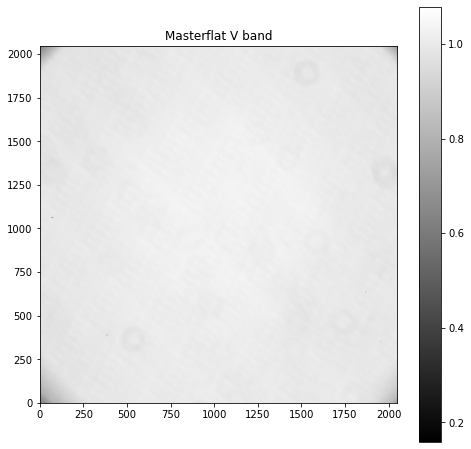

In [11]:
plt.figure(figsize=(8,8))
plt.imshow(masterflat_v,aspect='equal',origin='lower',cmap='gray')
plt.title('Masterflat V band')
plt.colorbar()
#plt.savefig('/home/abhishek/ATSOA/Photometry project/Project PPT/Masterflat_V.png',facecolor='white',edgecolor='white')
plt.show()

#### Bias, Flat and Cosmic ray correction

In [12]:
filesname="SA101_150_V*.fits"
file_names=sorted(glob.glob(filesname))

In [13]:
file_names

['SA101_150_V_01.fits',
 'SA101_150_V_01_cln.fits',
 'SA101_150_V_01_cln_ast.fits',
 'SA101_150_V_02.fits',
 'SA101_150_V_02_cln.fits',
 'SA101_150_V_02_cln_ast.fits',
 'SA101_150_V_03.fits',
 'SA101_150_V_03_cln.fits',
 'SA101_150_V_03_cln_ast.fits',
 'SA101_150_V_04.fits',
 'SA101_150_V_04_cln.fits',
 'SA101_150_V_04_cln_ast.fits']

In [20]:
image=ccdproc.CCDData.read(file_names[i],unit='adu')
header=fits.getheader(file_names[i])
bias_subtracted=ccdproc.subtract_bias(image,masterbias)
mean,median,std=sigma_clipped_stats()
plt.imshow(bias_sub)
flat_corrected=ccdproc.flat_correct(bias_subtracted,masterflat_v) #change masterflat for bands
#flat_corrected=(image.data-masterbias)/masterflat_v #change masterflat for different bands
cr_cleaned=ccdproc.cosmicray_lacosmic(flat_corrected,readnoise=7.5,sigclip=5,satlevel=65535,
                                      niter=20,cleantype='meanmask')
clean_file=file_names[i].replace('.fits','')
fits.writeto(clean_file+'_cln.fits',cr_cleaned,header,overwrite=True)
print('Image no-%i has been cleaned'%i)

Image no-0 has been cleaned
Image no-1 has been cleaned
Image no-2 has been cleaned
Image no-3 has been cleaned


In [21]:
clr_image=sorted(glob.glob('SA101_150_V_*_cln.fits'))
clr_image

['SA101_150_V_01_cln.fits',
 'SA101_150_V_02_cln.fits',
 'SA101_150_V_03_cln.fits',
 'SA101_150_V_04_cln.fits']

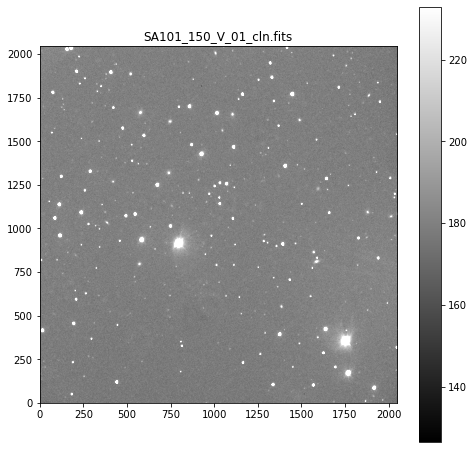

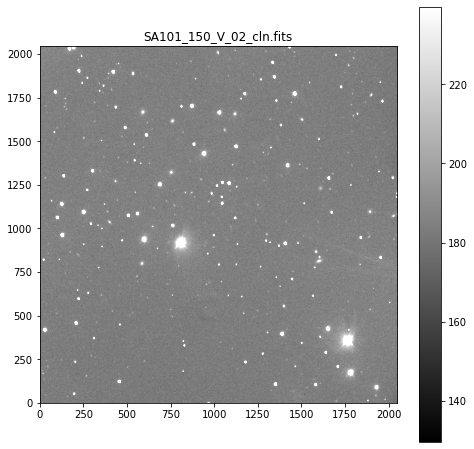

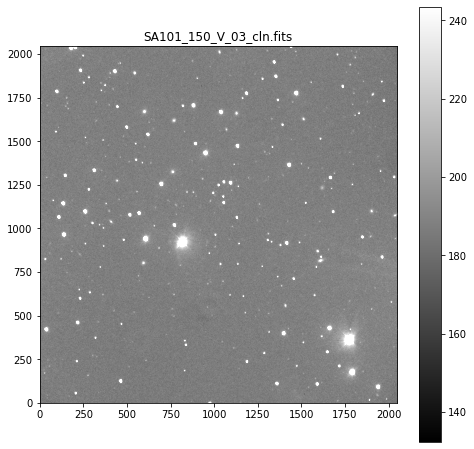

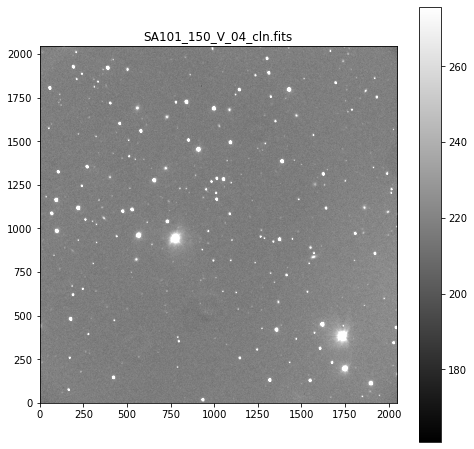

In [25]:
j=1
for i in range(len(clr_image)):
    science=fits.open(clr_image[i])
    header=science[0].header
    image=science[0].data
    #image=image[0] #get rid of extra axis
    mean,median,std=sigma_clipped_stats(image) #get statistics
    plt.figure(figsize=(8,8))
    plt.imshow(image,vmax=median+5*std,vmin=median-5*std,aspect='equal',origin='lower',cmap='gray')
    plt.title(clr_image[i])
    plt.colorbar()
    #plt.savefig(f'/home/abhishek/ATSOA/Photometry project/Project PPT/SA101_150_V_{j}_cln.png',facecolor='white',edgecolor='white')
    j+=1